In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
from ultralytics import YOLO
import torch
import torch.nn as nn
from loguru import logger
import os
import tensorrt as trt
import onnxruntime
import pytorch_quantization.nn as quant_nn
from pytorch_quantization.nn import TensorQuantizer  # 来自你QAT框架（如 MQBench 等）
import onnx
from onnxsim import simplify
print("ONNX Runtime版本:", onnxruntime.__version__)
print("可用设备:", onnxruntime.get_device())
print("支持Provider:", onnxruntime.get_available_providers())
print(f'trt version:{trt.__version__}')
print(f'torch cuda available:{torch.cuda.is_available()}')

ONNX Runtime版本: 1.22.0
可用设备: GPU
支持Provider: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
trt version:8.6.1
torch cuda available:True


In [3]:
def load_model(org_model_path, pt_model_path, device='cuda:0'):
    model = YOLO(org_model_path)
    model1 = torch.load(pt_model_path, map_location=device)["model"]
    model1.float()
    model1.eval()
    with torch.no_grad():
        model1.fuse()
    model.model = model1
    model.args = vars(model.args)
    model.model.args = model.args
    model.model.task = model.task
    return model

In [4]:
data_yaml_file = './datasets/my-coco-pose.yaml' # 测试数据
device = 'cuda:0'

# 原始的yolov8s-pose

In [5]:
org_pt_path = './weights/yolov8s-pose.pt'

In [6]:
dense_model = YOLO(org_pt_path, task='pose')

**预测**

In [6]:
results = dense_model.predict("datasets/coco-pose/images/val2017/000000000139.jpg",device=device)  # predict on an image


image 1/1 /data/xl/Projects/EdgeLite/datasets/coco-pose/images/val2017/000000000139.jpg: 448x640 1 person, 46.3ms
Speed: 4.1ms preprocess, 46.3ms inference, 393.8ms postprocess per image at shape (1, 3, 448, 640)


In [7]:
dense_model.device

device(type='cuda', index=0)

In [9]:
metrics = dense_model.val(data=data_yaml_file, device=device) 

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2792.2±981.5 MB/s, size: 120.7 KB)


val: Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corrupt
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50


                   all       2346       6352      0.868      0.864       0.93      0.743      0.855      0.804      0.858      0.606
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /data/xl/Projects/ultralytics/runs/pose/val435/predictions.json...

Evaluating faster-coco-eval mAP using /data/xl/Projects/ultralytics/runs/pose/val435/predictions.json and datasets/coco-pose/annotations/person_keypoints_val2017.json...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished...
DONE (t=0.47s).
Accumulating evaluation results...
COCOeval_opt.accumulate() finished...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.638
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [24]:
dense_model.info()

YOLOv8s-pose summary (fused): 81 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs


(81, 11615724, 0, 30.190670400000002)

In [23]:
logger.info(f"Original model fp32 pt-->YOLO load model evaluate inference speed:{metrics.speed['inference']:.1f} ms")

2025-07-04 17:25:42.112 | INFO     | __main__:<module>:1 - Original model fp32 pt-->YOLO load model evaluate inference speed:1.0 ms


# FP16->TRT engine

* 在动态情况下只有minShapes=maxShapes=optShapes=1x3x640x640->即静态，相当于默认的官方导出engine(dynamic=False)
* 否则minShapes=images:batchx3x320x320, maxShapes=images:batchx3x640x640 可以跑
* engine_model.val()

**官方导出engine, 静态**

In [10]:
dense_model.export(format='engine', half=True, device=device)

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
YOLOv8s-pose summary (fused): 81 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs

PyTorch: starting from 'weights/yolov8s-pose.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 56, 8400) (22.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 1.2s, saved as 'weights/yolov8s-pose.onnx' (44.6 MB)

TensorRT: starting export with TensorRT 8.6.1...
[07/07/2025-19:32:44] [TRT] [I] [MemUsageChange] Init CUDA: CPU +1, GPU +0, now: CPU 2199, GPU 6023 (MiB)
[07/07/2025-19:32:52] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +1444, GPU +270, now: CPU 3720, GPU 6293 (MiB)
[07/07/2025-19:32:52] [TRT] [I] ----------------------------------------------------------------
[07/07/2025-19:32:52] [TRT] [I] Input filename:   weights/yolov8s-pose.onnx
[07/07/2025-19:32:52] [TRT] [I] ONNX IR version:  0.0.9
[07/07/2025-

'weights/yolov8s-pose.engine'

**官方导出engine, 动态**

In [6]:
# TensorRT FP16
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
fp16_trt_engine = dense_model.export(format="engine", imgsz=640, dynamic=True, verbose=False, batch=8, workspace=2, half=True)

WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
YOLOv8s-pose summary (fused): 81 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs

PyTorch: starting from 'weights/yolov8s-pose.pt' with input shape (8, 3, 640, 640) BCHW and output shape(s) (8, 56, 8400) (22.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 4.0s, saved as 'weights/yolov8s-pose.onnx' (44.4 MB)

TensorRT: starting export with TensorRT 8.6.1...
[07/07/2025-20:37:09] [TRT] [I] [MemUsageChange] Init CUDA: CPU +2, GPU +0, now: CPU 893, GPU 2255 (MiB)
[07/07/2025-20:37:16] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +1445, GPU +266, now: CPU 2414, GPU 2521 (MiB)


KeyboardInterrupt: 

模型文件路径原始模型的pt文件路径将'pt'替换为'engine
即'./weights/yolov8s-pose.pt'->'./weights/yolov8s-pose.engine'

对其重命名:

In [7]:
import os
os.rename('./weights/yolov8s-pose.engine', './weights/yolov8s-pose-fp16.engine')

In [60]:
# fp16_trt_engine = YOLO('./weights/yolov8s-pose-fp16.engine', task='pose')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
fp16_trt_engine = YOLO('./weights/yolov8s-pose-fp16.engine', task='pose')

**动态情况下一定要设置rect=False(特别是imgsz=640固定shape时)**

In [61]:
metrics = fp16_trt_engine.val(data=data_yaml_file, batch=16,imgsz=640, rect=False, verbose=False, device=device)
# metrics = model.val(data=data_yaml_file, batch=1,imgsz=640, rect=True, verbose=False, device=device) # 

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
Loading weights/yolov8s-pose-fp16.engine for TensorRT inference...
[07/09/2025-11:41:11] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[07/09/2025-11:41:11] [TRT] [I] Loaded engine size: 26 MiB
[07/09/2025-11:41:11] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +22, now: CPU 0, GPU 1137 (MiB)
[07/09/2025-11:41:12] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +272, now: CPU 1, GPU 1409 (MiB)
WARNING ⚠️ Metadata not found for 'model=./weights/yolov8s-pose-fp16.engine'
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1091.5±192.2 MB/s, size: 155.3 KB)


val: Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2346/2346 [00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 147/


                   all       2346       6352      0.868      0.855      0.925      0.733      0.854      0.807      0.856      0.605
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /data/xl/Projects/ultralytics/runs/pose/val576/predictions.json...

Evaluating faster-coco-eval mAP using /data/xl/Projects/ultralytics/runs/pose/val576/predictions.json and datasets/coco-pose/annotations/person_keypoints_val2017.json...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished...
DONE (t=0.57s).
Accumulating evaluation results...
COCOeval_opt.accumulate() finished...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.622
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [62]:
metrics.speed

{'preprocess': 0.12346564153747637,
 'inference': 0.383697569057447,
 'loss': 0.000414514766477258,
 'postprocess': 0.46280918511675584}

In [47]:
fp16_infer_time = metrics.speed['inference']

In [48]:
logger.info(f"fp16 trt engine-->YOLO load model evaluate inference speed:{fp16_infer_time:.1f} ms")

2025-07-04 17:51:29.132 | INFO     | __main__:<module>:1 - fp16 trt engine-->YOLO load model evaluate inference speed:0.8 ms


In [36]:
!trtexec --loadEngine=weights/yolov8s-pose-fp16.engine --shapes=images:1x3x640x640

&&&& RUNNING TensorRT.trtexec [TensorRT v100700] [b23] # trtexec --loadEngine=weights/yolov8s-pose-fp16.engine --shapes=images:1x3x640x640
[07/05/2025-16:42:41] [I] TF32 is enabled by default. Add --noTF32 flag to further improve accuracy with some performance cost.
[07/05/2025-16:42:41] [I] === Model Options ===
[07/05/2025-16:42:41] [I] Format: *
[07/05/2025-16:42:41] [I] Model: 
[07/05/2025-16:42:41] [I] Output:
[07/05/2025-16:42:41] [I] 
[07/05/2025-16:42:41] [I] === System Options ===
[07/05/2025-16:42:41] [I] Device: 0
[07/05/2025-16:42:41] [I] DLACore: 
[07/05/2025-16:42:41] [I] Plugins:
[07/05/2025-16:42:41] [I] setPluginsToSerialize:
[07/05/2025-16:42:41] [I] dynamicPlugins:
[07/05/2025-16:42:41] [I] ignoreParsedPluginLibs: 0
[07/05/2025-16:42:41] [I] 
[07/05/2025-16:42:41] [I] === Inference Options ===
[07/05/2025-16:42:41] [I] Batch: Explicit
[07/05/2025-16:42:41] [I] Input inference shape : images=1x3x640x640
[07/05/2025-16:42:41] [I] Iterations: 10
[07/05/2025-16:42:41] [I

In [35]:
logger.info(f'fp16 trt engine, batch 16, gpu mean time/per img: 6.75ms')

2025-07-05 16:42:33.565 | INFO     | __main__:<module>:1 - fp16 trt engine, batch 16, gpu mean time/per img: 6.75ms


In [37]:
logger.info(f'fp16 trt engine, batch 1, gpu mean time/per img: 1.3ms')

2025-07-05 16:43:17.108 | INFO     | __main__:<module>:1 - fp16 trt engine, batch 1, gpu mean time/per img: 1.3ms


# PTQ

In [9]:
# 官方ptq,导出精度十分低！
dense_model.export(format='engine', imgsz=640, dynamic=True, verbose=False, batch=8, workspace=2, int8=True, data=data_yaml_file)

WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
YOLOv8s-pose summary (fused): 81 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs

PyTorch: starting from 'weights/yolov8s-pose.pt' with input shape (8, 3, 640, 640) BCHW and output shape(s) (8, 56, 8400) (22.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 4.1s, saved as 'weights/yolov8s-pose.onnx' (44.4 MB)

TensorRT: starting export with TensorRT 8.6.1...
TensorRT: collecting INT8 calibration images from 'data=./datasets/my-coco-pose.yaml'
Fast image access ✅ (ping: 0.0±0.0 ms, read: 3612.7±830.6 MB/s, size: 173.9 KB)


Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corrupt: 1

[07/07/2025-21:43:56] [TRT] [I] The logger passed into createInferBuilder differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.


[07/07/2025-21:43:56] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 896, GPU 1117 (MiB)
[07/07/2025-21:44:03] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +1445, GPU +266, now: CPU 2417, GPU 1383 (MiB)
[07/07/2025-21:44:03] [TRT] [I] ----------------------------------------------------------------
[07/07/2025-21:44:03] [TRT] [I] Input filename:   weights/yolov8s-pose.onnx
[07/07/2025-21:44:03] [TRT] [I] ONNX IR version:  0.0.9
[07/07/2025-21:44:03] [TRT] [I] Opset version:    19
[07/07/2025-21:44:03] [TRT] [I] Producer name:    pytorch
[07/07/2025-21:44:03] [TRT] [I] Producer version: 2.4.1
[07/07/2025-21:44:03] [TRT] [I] Domain:           
[07/07/2025-21:44:03] [TRT] [I] Model version:    0
[07/07/2025-21:44:03] [TRT] [I] Doc string:       
[07/07/2025-21:44:03] [TRT] [I] ----------------------------------------------------------------
[07/07/2025-21:44:03] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while Te

'weights/yolov8s-pose.engine'

In [10]:
import os
os.rename('./weights/yolov8s-pose.engine', './weights/yolov8s-pose-ptq.engine')

In [ ]:
# 非官方手写ptq
!python main_quant.py --weight weights/yolov8s-pose.pt --onnx_path weights/yolov8s-pose.onnx --engine_path weights/yolov8s-pose-ptq.engine \
--cali_data_path datasets/coco-pose/images/train2017 --cali_size 5000 --output_dir output/yolov8s-pose-ptq --output_dir output/yolov8s-pose-ptq \
--quant ptq --batch_size 1 --eval

In [11]:
ptq_engine_path = 'weights/yolov8s-pose-ptq.engine'
# ptq_engine_path = 'weights/yolov8s-pose.engine'

In [12]:
ptq_trt_engine = YOLO(ptq_engine_path, task='pose')

In [14]:
metrics = ptq_trt_engine.val(data=data_yaml_file, rect=False, verbose=False, device=device)

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
Loading weights/yolov8s-pose-ptq.engine for TensorRT inference...
[07/07/2025-22:00:53] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[07/07/2025-22:00:53] [TRT] [I] Loaded engine size: 14 MiB
[07/07/2025-22:00:53] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +11, now: CPU 0, GPU 314 (MiB)
[07/07/2025-22:00:53] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +292, now: CPU 1, GPU 606 (MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1832.8±822.0 MB/s, size: 162.0 KB)


val: Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corru
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP


                   all       2346       6352      0.867      0.841      0.915      0.716      0.839      0.792      0.838      0.555
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /data/xl/Projects/ultralytics/runs/pose/val487/predictions.json...

Evaluating faster-coco-eval mAP using /data/xl/Projects/ultralytics/runs/pose/val487/predictions.json and datasets/coco-pose/annotations/person_keypoints_val2017.json...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished...
DONE (t=0.99s).
Accumulating evaluation results...
COCOeval_opt.accumulate() finished...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [36]:
ptq_infer_time = metrics.speed['inference']

In [37]:
logger.info(f"ptq trt engine-->YOLO load model evaluate inference speed:{ptq_infer_time:.1f} ms")

2025-07-05 12:46:43.032 | INFO     | __main__:<module>:1 - ptq trt engine-->YOLO load model evaluate inference speed:0.7 ms


In [54]:
logger.info(f"ptq vs.fp16 trt engine, speed up {fp16_infer_time/ptq_infer_time:.1f}x")

2025-07-04 17:53:33.794 | INFO     | __main__:<module>:1 - ptq vs.fp16 trt engine, speed up 1.1x


# QAT

In [98]:
qat_pt_path = 'weights/yolov8s-pose-qat.pt'

In [99]:
qat_model = load_model("weights/yolov8s-pose.pt", 'weights/yolov8s-pose-qat.pt')

/tmp/ipykernel_3799730/2763210459.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load(pt_model_path, map_location=device)["model"]


In [97]:
data_yaml_file = './datasets/my-coco-pose.yaml'
# metrics = qat_model .val(data=data_yaml_file, batch=16, device='cuda:0') 
metrics = qat_model.val(data=data_yaml_file)

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 773.5±246.4 MB/s, size: 176.7 KB)


val: Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2346/2346 [00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 147/


                   all       2346       6352      0.871      0.854      0.928      0.701      0.846      0.808      0.857      0.592
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /data/xl/Projects/ultralytics/runs/pose/val604/predictions.json...

Evaluating faster-coco-eval mAP using /data/xl/Projects/ultralytics/runs/pose/val604/predictions.json and datasets/coco-pose/annotations/person_keypoints_val2017.json...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished...
DONE (t=0.62s).
Accumulating evaluation results...
COCOeval_opt.accumulate() finished...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [100]:
def enable_all_fake_quant(module):
    for m in module.modules():
        if isinstance(m, quant_nn.TensorQuantizer):
            m._fake_quant = True
    return module
def validate_onnx(file):
    model = onnx.load(file)
    model_simp, check = simplify(
        model,
        skip_fuse_bn=True,
        test_input_shapes={"images": [1, 3, 640, 640]},
    )
    onnx.save(model_simp, file)
    print(f"onnx validate finished , save to: {file}")
    print("========================\n")
qat_model = enable_all_fake_quant(qat_model)
path = qat_model.export(format='onnx', dynamic=True, imgsz=640, verbose=False, batch=16, workspace=2)

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CPU (Intel Xeon Platinum 8457C)

PyTorch: starting from 'yolov8s-pose.yaml' with input shape (16, 3, 640, 640) BCHW and output shape(s) (16, 56, 8400) (0.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 8.0s, saved as 'yolov8s-pose.onnx' (44.6 MB)

Export complete (12.2s)
Results saved to /data/xl/Projects/EdgeLite
Predict:         yolo predict task=pose model=yolov8s-pose.onnx imgsz=640  
Validate:        yolo val task=pose model=yolov8s-pose.onnx imgsz=640 data=./datasets/my-coco-pose.yaml  
Visualize:       https://netron.app


In [8]:
path

'yolov8s-pose.onnx'

In [10]:
qat_model.model_name

'weights/yolov8s-pose.pt'

In [101]:
validate_onnx('yolov8s-pose.onnx')

onnx validate finished , save to: yolov8s-pose.onnx



In [102]:
import os
os.rename(path, './weights/yolov8s-pose-qat.onnx')

In [103]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [120]:
!trtexec --onnx=./weights/yolov8s-pose-qat.onnx --int8 --fp16 --saveEngine=./weights/yolov8s-pose-qat.engine --minShapes=images:1x3x640x640 --optShapes=images:16x3x640x640 --maxShapes=images:16x3x640x640

&&&& RUNNING TensorRT.trtexec [TensorRT v8601] # trtexec --onnx=./weights/yolov8s-pose-qat.onnx --int8 --fp16 --saveEngine=./weights/yolov8s-pose-qat.engine --minShapes=images:1x3x640x640 --optShapes=images:16x3x640x640 --maxShapes=images:16x3x640x640
[07/09/2025-13:01:29] [I] === Model Options ===
[07/09/2025-13:01:29] [I] Format: ONNX
[07/09/2025-13:01:29] [I] Model: ./weights/yolov8s-pose-qat.onnx
[07/09/2025-13:01:29] [I] Output:
[07/09/2025-13:01:29] [I] === Build Options ===
[07/09/2025-13:01:29] [I] Max batch: explicit batch
[07/09/2025-13:01:29] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[07/09/2025-13:01:29] [I] minTiming: 1
[07/09/2025-13:01:29] [I] avgTiming: 8
[07/09/2025-13:01:29] [I] Precision: FP32+FP16+INT8
[07/09/2025-13:01:29] [I] LayerPrecisions: 
[07/09/2025-13:01:29] [I] Layer Device Types: 
[07/09/2025-13:01:29] [I] Calibration: Dynamic
[07/09/2025-13:01:29] [I] Refit: Disabled
[07/09/2025-13:01:29] [I] Ve

In [121]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
qat_engine_path = './weights/yolov8s-pose-qat.engine'
qat_model = YOLO(qat_engine_path, task='pose')

In [127]:
metrics = qat_model.val(data=data_yaml_file,batch=16, rect=False, device=device)

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
Loading weights/yolov8s-pose-qat.engine for TensorRT inference...
[07/09/2025-14:39:23] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[07/09/2025-14:39:23] [TRT] [I] Loaded engine size: 15 MiB
[07/09/2025-14:39:23] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +12, now: CPU 1, GPU 403 (MiB)
[07/09/2025-14:39:23] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +184, now: CPU 2, GPU 587 (MiB)
WARNING ⚠️ Metadata not found for 'model=./weights/yolov8s-pose-qat.engine'
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 788.0±87.7 MB/s, size: 163.2 KB)


val: Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2346/2346 [00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 147/


                   all       2346       6352      0.871      0.847      0.922        0.7      0.851      0.801      0.854      0.591
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /data/xl/Projects/ultralytics/runs/pose/val624/predictions.json...

Evaluating faster-coco-eval mAP using /data/xl/Projects/ultralytics/runs/pose/val624/predictions.json and datasets/coco-pose/annotations/person_keypoints_val2017.json...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished...
DONE (t=0.57s).
Accumulating evaluation results...
COCOeval_opt.accumulate() finished...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

**--int8(fp32+int8)**

In [119]:
metrics.speed

{'preprocess': 0.1592556812990225,
 'inference': 0.3285312433909698,
 'loss': 0.00043988958491808007,
 'postprocess': 0.4968066672113297}

**--int8 --fp16 (fp32+fp16+int8)**

In [112]:
metrics.speed

{'preprocess': 0.14382310366283432,
 'inference': 0.20884833815098697,
 'loss': 0.0004549553452690036,
 'postprocess': 0.5027503953239891}

# prune

* 剪枝后的yolov8s-pose的pt->"./output/yolov8s-pose-prune-sp0.5-epoch60/step_19_finetune/weights/best.pt"
* 原始的yolov8s-pose的pt->'./weights/yolov8s-pose.pt'

In [77]:
# pt_path = "./output/yolov8s-pose-prune-sp0.5-epoch60/step_19_finetune/weights/best.pt"
pt_path = "./output/yolov8s-pose-prune-sp0.3-epochs120/step_6_finetune/weights/best.pt"
# pt_path = "./output/yolov8s-pose-prune-sp0.3-epoch60/step_19_finetune/weights/best.pt"

In [82]:
pruned_model = YOLO(pt_path, task='pose')
# pruned_model = load_model(org_pt_path, pt_path)

In [85]:
metrics = pruned_model.val(data=data_yaml_file, batch=16, device=device) 

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1124.7±172.8 MB/s, size: 204.4 KB)


val: Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2346/2346 [00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 147/


                   all       2346       6352      0.874      0.849      0.926      0.733      0.857      0.794      0.847       0.58
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /data/xl/Projects/ultralytics/runs/pose/val589/predictions.json...

Evaluating faster-coco-eval mAP using /data/xl/Projects/ultralytics/runs/pose/val589/predictions.json and datasets/coco-pose/annotations/person_keypoints_val2017.json...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished...
DONE (t=0.56s).
Accumulating evaluation results...
COCOeval_opt.accumulate() finished...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [23]:
logger.info(f"pruning sp0.5 pt-->YOLO load model evaluate inference speed:{metrics.speed['inference']:.1f} ms")

2025-07-07 22:03:47.308 | INFO     | __main__:<module>:1 - pruning sp0.5 pt-->YOLO load model evaluate inference speed:0.5 ms


In [24]:
logger.info(f"pruning sp0.3 pt-->YOLO load model evaluate inference speed:{metrics.speed['inference']:.1f} ms")

2025-07-07 22:03:47.313 | INFO     | __main__:<module>:1 - pruning sp0.3 pt-->YOLO load model evaluate inference speed:0.5 ms


**注意,我们发现，多次运行会得到不一样的结果，取值分别有1.3、0.9、0.8、0.6、0.5、0.4ms**
* 可以YOLO加载model以及load_model加载model多次切换运行，就可以得到0.4ms

**Pruned fp16 trt engine**

In [86]:
pruned_fp16_engine_path = pruned_model.export(format='engine', imgsz=640, dynamic=True, verbose=False, batch=16, workspace=2, half=True)

WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)

PyTorch: starting from 'output/yolov8s-pose-prune-sp0.3-epochs120/step_6_finetune/weights/best.pt' with input shape (16, 3, 640, 640) BCHW and output shape(s) (16, 56, 8400) (33.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 3.9s, saved as 'output/yolov8s-pose-prune-sp0.3-epochs120/step_6_finetune/weights/best.onnx' (33.2 MB)

TensorRT: starting export with TensorRT 8.6.1...
[07/09/2025-11:53:42] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 1822, GPU 18753 (MiB)
[07/09/2025-11:53:48] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +1443, GPU +252, now: CPU 3265, GPU 19005 (MiB)
[07/09/2025-11:53:48] [TRT] [I] ----------------------------------------------------------------
[07/09/2025-11:53:48] [TRT] [I] Input filename:   outpu

In [44]:
pruned_model.export(format='onnx', dynamic=True, imgsz=640, simplify=True, device=device)

Ultralytics 8.3.155 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)

PyTorch: starting from 'output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 56, 8400) (14.5 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 3.4s, saved as 'output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.onnx' (13.5 MB)

Export complete (3.4s)
Results saved to /data/xl/Projects/EdgeLite/output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights
Predict:         yolo predict task=pose model=output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.onnx imgsz=640  
Validate:        yolo val task=pose model=output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.onnx imgsz=640 data=./datasets/my-coco-pose.yaml  
Visualize:       https://netron.app


'output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.onnx'

In [46]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
!trtexec --onnx='output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.onnx' --fp16 --saveEngine='output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.engine' --minShapes=images:1x3x640x640 --maxShapes=images:16x3x640x640 --optShapes=images:12x3x640x640

&&&& RUNNING TensorRT.trtexec [TensorRT v100700] [b23] # trtexec --onnx=output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.onnx --fp16 --saveEngine=output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.engine --minShapes=images:1x3x640x640 --maxShapes=images:16x3x640x640 --optShapes=images:12x3x640x640
[07/05/2025-12:58:32] [I] === Model Options ===
[07/05/2025-12:58:32] [I] Format: ONNX
[07/05/2025-12:58:32] [I] Model: output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.onnx
[07/05/2025-12:58:32] [I] Output:
[07/05/2025-12:58:32] [I] === Build Options ===
[07/05/2025-12:58:32] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[07/05/2025-12:58:32] [I] avgTiming: 8
[07/05/2025-12:58:32] [I] Precision: FP32+FP16
[07/05/2025-12:58:32] [I] LayerPrecisions: 
[07/05/2025-12:58:32] [I] Layer Device Types: 
[07/05/2025-12:58:32] [I] Calibration: 
[07/05/2025-12:58

In [49]:
pruned_fp16_engine_path

'output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.engine'

In [87]:
# pruned_fp16_engine_path = 'output/yolov8s-pose-prune-sp0.5-epoch60/step_18_finetune/weights/best.engine'
pruned_fp16_engine_path = 'output/yolov8s-pose-prune-sp0.3-epochs120/step_6_finetune/weights/best.engine'

In [27]:
os.rename(pruned_fp16_engine_path, './weights/yolov8s-pose-pruned-sp0.5-fp16.engine')

In [88]:
# pruned_fp16_trt_engine = YOLO('./weights/yolov8s-pose-pruned-sp0.3-fp16.engine', task='pose')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
pruned_fp16_trt_engine = YOLO(pruned_fp16_engine_path, task='pose')

In [90]:
metrics = pruned_fp16_trt_engine.val(data=data_yaml_file,batch=1, rect=False, verbose=False, device=device)

Ultralytics 8.3.162 🚀 Python-3.10.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA L40, 45386MiB)
Loading output/yolov8s-pose-prune-sp0.3-epochs120/step_6_finetune/weights/best.engine for TensorRT inference...
[07/09/2025-12:00:28] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[07/09/2025-12:00:28] [TRT] [I] Loaded engine size: 21 MiB
[07/09/2025-12:00:28] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +18, now: CPU 0, GPU 1179 (MiB)
[07/09/2025-12:00:28] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +1144, now: CPU 1, GPU 2323 (MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1196.1±843.1 MB/s, size: 102.1 KB)


val: Scanning /data/xl/Projects/EdgeLite/datasets/coco-pose/labels/val2017.cache... 2346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2346/2346 [00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 147/


                   all       2346       6352      0.867      0.846      0.922      0.726      0.845      0.804      0.847      0.577
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving /data/xl/Projects/ultralytics/runs/pose/val591/predictions.json...

Evaluating faster-coco-eval mAP using /data/xl/Projects/ultralytics/runs/pose/val591/predictions.json and datasets/coco-pose/annotations/person_keypoints_val2017.json...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished...
DONE (t=0.56s).
Accumulating evaluation results...
COCOeval_opt.accumulate() finished...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [91]:
metrics.speed

{'preprocess': 0.12907418602035847,
 'inference': 0.42045535266642337,
 'loss': 0.000513308947129399,
 'postprocess': 0.536118865734441}

In [68]:
metrics.speed

{'preprocess': 0.1036744346033912,
 'inference': 0.4730086527702868,
 'loss': 0.00043406574220697494,
 'postprocess': 0.44061620816991737}

In [31]:
!trtexec --loadEngine=weights/yolov8s-pose-pruned-sp0.5-fp16.engine --shapes=images:16x3x640x640

&&&& RUNNING TensorRT.trtexec [TensorRT v100700] [b23] # trtexec --loadEngine=weights/yolov8s-pose-pruned-sp0.5-fp16.engine --shapes=images:16x3x640x640
[07/05/2025-16:30:44] [I] TF32 is enabled by default. Add --noTF32 flag to further improve accuracy with some performance cost.
[07/05/2025-16:30:44] [I] === Model Options ===
[07/05/2025-16:30:44] [I] Format: *
[07/05/2025-16:30:44] [I] Model: 
[07/05/2025-16:30:44] [I] Output:
[07/05/2025-16:30:44] [I] 
[07/05/2025-16:30:44] [I] === System Options ===
[07/05/2025-16:30:44] [I] Device: 0
[07/05/2025-16:30:44] [I] DLACore: 
[07/05/2025-16:30:44] [I] Plugins:
[07/05/2025-16:30:44] [I] setPluginsToSerialize:
[07/05/2025-16:30:44] [I] dynamicPlugins:
[07/05/2025-16:30:44] [I] ignoreParsedPluginLibs: 0
[07/05/2025-16:30:44] [I] 
[07/05/2025-16:30:44] [I] === Inference Options ===
[07/05/2025-16:30:44] [I] Batch: Explicit
[07/05/2025-16:30:44] [I] Input inference shape : images=16x3x640x640
[07/05/2025-16:30:44] [I] Iterations: 10
[07/05/20

In [39]:
!trtexec --loadEngine=weights/yolov8s-pose-pruned-sp0.5-fp16.engine --shapes=images:1x3x640x640

&&&& RUNNING TensorRT.trtexec [TensorRT v100700] [b23] # trtexec --loadEngine=weights/yolov8s-pose-pruned-sp0.5-fp16.engine --shapes=images:1x3x640x640
[07/05/2025-16:45:43] [I] TF32 is enabled by default. Add --noTF32 flag to further improve accuracy with some performance cost.
[07/05/2025-16:45:43] [I] === Model Options ===
[07/05/2025-16:45:43] [I] Format: *
[07/05/2025-16:45:43] [I] Model: 
[07/05/2025-16:45:43] [I] Output:
[07/05/2025-16:45:43] [I] 
[07/05/2025-16:45:43] [I] === System Options ===
[07/05/2025-16:45:43] [I] Device: 0
[07/05/2025-16:45:43] [I] DLACore: 
[07/05/2025-16:45:43] [I] Plugins:
[07/05/2025-16:45:43] [I] setPluginsToSerialize:
[07/05/2025-16:45:43] [I] dynamicPlugins:
[07/05/2025-16:45:43] [I] ignoreParsedPluginLibs: 0
[07/05/2025-16:45:43] [I] 
[07/05/2025-16:45:43] [I] === Inference Options ===
[07/05/2025-16:45:43] [I] Batch: Explicit
[07/05/2025-16:45:43] [I] Input inference shape : images=1x3x640x640
[07/05/2025-16:45:43] [I] Iterations: 10
[07/05/2025

In [38]:
logger.info(f'pruning sp0.5 fp16 trt engine, batch 16, gpu mean time/per img: 2.9ms')

2025-07-05 16:45:31.164 | INFO     | __main__:<module>:1 - pruning sp0.5 fp16 trt engine, batch 16, gpu mean time/per img: 2.9ms


In [40]:
logger.info(f'pruning sp0.5 fp16 trt engine, batch 1, gpu mean time/per img: 0.9ms')

2025-07-05 16:46:06.467 | INFO     | __main__:<module>:1 - pruning sp0.5 fp16 trt engine, batch 1, gpu mean time/per img: 0.9ms


In [39]:
logger.info(f"pruning sp0.3 fp16 engine-->YOLO load model evaluate inference speed:{metrics.speed['inference']:.1f} ms")

2025-07-04 23:35:11.764 | INFO     | __main__:<module>:1 - pruning sp0.3 fp16 engine-->YOLO load model evaluate inference speed:0.7 ms


In [40]:
logger.info(f"pruning sp0.5 fp16 engine-->YOLO load model evaluate inference speed:{metrics.speed['inference']:.1f} ms")

2025-07-04 23:35:14.649 | INFO     | __main__:<module>:1 - pruning sp0.5 fp16 engine-->YOLO load model evaluate inference speed:0.7 ms


**非动态情况下导出的engine都是0.7ms**

In [7]:
logger.info(f"pruning sp0.5 fp16 engine from function load_model-->YOLO load model evaluate inference speed:{metrics.speed['inference']:.1f} ms")

2025-07-04 21:46:30.015 | INFO     | __main__:<module>:1 - pruning sp0.5 fp16 engine from function load_model-->YOLO load model evaluate inference speed:0.2 ms


注意我们推断0.2ms是动态shape,此情况下类似与--minShapes=images:16x3x320x320 --maxShapes=images:16x3x1024x1024 --optShapes=images:16x3x640x640
* 推理速度极快
* 但精度却掉点十分严重

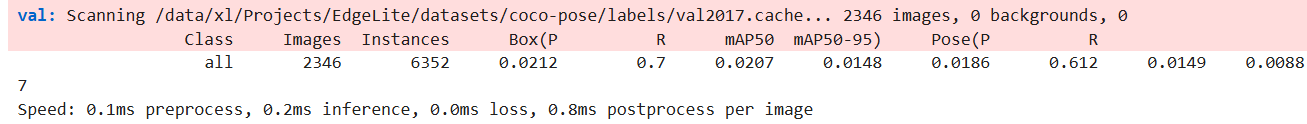

目前我们尝试的参数中，只用--minShapes=images:1x3x640x640 --maxShapes=images:1x3x640x640 --optShapes=images:1x3x640x640
* 能准确跑出精确度
* 但推理速度为1ms、0.9ms、0.8ms、0.7ms等值
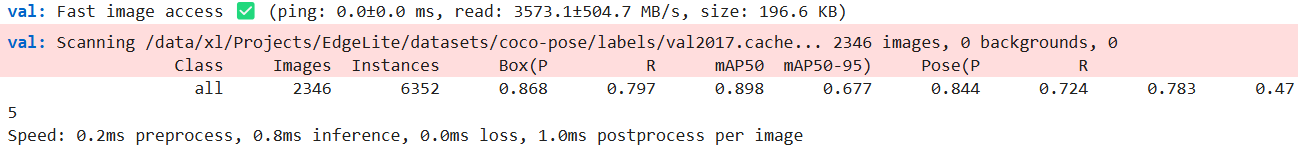

**利用YOLO导出的静态engine(dynamic不设置)与onnx导出并在trtextec中设置1x3x640x640是等效的-->静态**
* 都可以正确预测精度
* 但是推理速度较慢-->0.8-1ms

**要想动态推理，需要单独写一个engine的推理代码,在数据处理这一阶段满足动态处理要求**